In [1]:
# Import modules

import csv
import cv2
import numpy as np
import sklearn
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
### Define a helper function that plots on array of images
### in a nx by ny grid, and optionally saves to file

def plot_images(images,nx,ny,figsize=(15,10),titles=[],fontsize=36,cmap=None,saveas=""):

    fig = plt.figure(figsize=figsize)

    for idx in range(len(images)):
    
        plt.subplot(nx,ny,idx+1)
        plt.imshow(images[idx],cmap=cmap)
        if(len(titles) > idx):
            plt.title(titles[idx],fontsize=fontsize)
    
    display(fig)
    if saveas:
        plt.savefig(saveas,bbox_inches="tight")
    plt.close()
        

In [3]:
# Set adjustable parameters

nb_epoch = 7 # 4 or 5 epochs seems to be best (validation loss stops decreasing)
batch_size = 64 # Number of images to process per iteration

steering_correction = 0.3 # This is added/subtracted from steering_angle
                          # for images taken by left/right mounted cameras.

img_size = (160,320,3)
input_shape = (1,160,320,3)
img_cropping = ((70,25), (0,0)) # Crop image to remove above + below road

data_base_path = '../Driving_Data/'
data_folder_names = ['Track_1_Center/','Track_1_Recover_v2/','Track_1_Recover_v3/']
log_file_name = 'driving_log.csv'

# Set max_num_samples = -1 to do all samples
# Set to a small value for quick testing on slow processor
max_num_samples = -1


In [4]:
# Organize the data for processing
# Each sample consists of an image filename and a steering angle.
# Image filenames are used (instead of images) so that images can
# be loaded one-by-one using a generator (instead of all at once).

image_paths = []
steering_angles = []
testing_angles = []

# Load data from all folders in data_folder_names
for data_folder_name in data_folder_names:    
   
    # Read lines from the csvfile in each data folder
    with open(data_base_path+data_folder_name+log_file_name) as csvfile:
        reader = csv.reader(csvfile)
        driving_log_lines = []
        for line in reader:            
            driving_log_lines.append(line)
    
    # Parse the lines to get steering_angles,
    # and adjust the steering_angles for left and right images.
    for line in driving_log_lines:
        
        # Create adjusted steering steering_angles for the side camera images
        # In steering_adjustment, the key is in {0,1,2}
        # 0 is for center image, 1 is for left image, 2 is for right image
        steering_adjustment = {0:0, 1: steering_correction, 2: -steering_correction}
        
        testing_angles.append(float(line[3]))

        for line_idx in range(3):
            
            img_path = line[line_idx]
            img_file_name = img_path.split('/')[-1]
            image_path = data_base_path+data_folder_name+'IMG/'+img_file_name
            image_paths.append(image_path)
            
            steering_angle = float(line[3]) + steering_adjustment[line_idx]            
            steering_angles.append(float(steering_angle))            

samples = list(zip(image_paths,steering_angles))

# Print out some info about the number of samples
print("Total number of samples available: {}".format(len(samples)))
if (max_num_samples != -1):
    samples = samples[0:max_num_samples]
print("Total number of samples used: {}".format(len(samples)))



Total number of samples available: 37491
Total number of samples used: 37491


Image path: ../Driving_Data/Track_1_Center/IMG/center_2017_10_12_09_23_38_683.jpg
Steering angle: -0.1032577


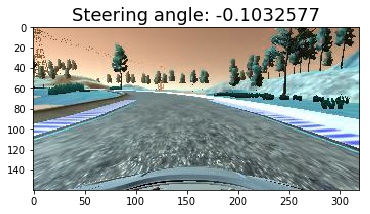

Image path: ../Driving_Data/Track_1_Center/IMG/right_2017_10_12_09_23_15_120.jpg
Steering angle: -0.33235554


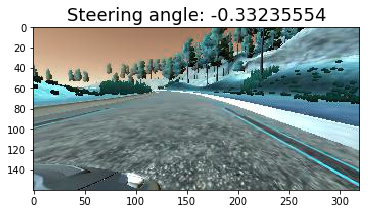

Image path: ../Driving_Data/Track_1_Recover_v2/IMG/right_2017_10_19_13_01_51_215.jpg
Steering angle: 0.7


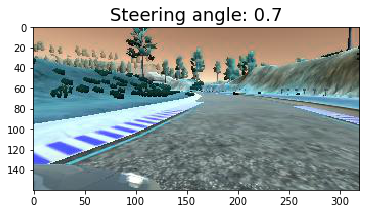

Image path: ../Driving_Data/Track_1_Recover_v2/IMG/center_2017_10_19_13_19_15_862.jpg
Steering angle: -1.0


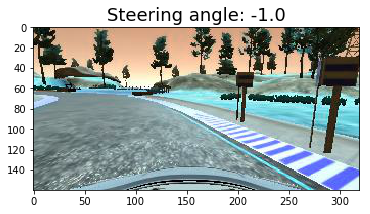

In [16]:
# Plot example images

#selected_samples = [2000,3000,8000,9001,20000,30000]
selected_samples = [3000,2000,20000,30000]
save_names = ["writeup_images/center_center.jpg",
              "writeup_images/center_right.jpg",
              "writeup_images/recover_right.jpg",
              "writeup_images/recover_center.jpg"]

for idx in range(len(selected_samples)):
    sample_num = selected_samples[idx]
    image_path, angle = samples[sample_num]
    image = cv2.imread(image_path)
    print("Image path: {}".format(image_path))
    print("Steering angle: {}".format(angle))
    
    title = "Steering angle: {}".format(angle)
    plot_images([image],1,1,figsize=(6,3),titles=[title],fontsize=18,
                saveas=save_names[idx])
    
    #plt.figure()
    #plt.imshow(image)
    #plt.title("Steering angle: {}".format(angle))

In [6]:
# Split the data into train, validate, test

from sklearn.model_selection import train_test_split

trainvalid_samples, test_samples = train_test_split(samples, test_size=0.2)
train_samples, validation_samples = train_test_split(trainvalid_samples, test_size=0.2)


In [7]:
# Create generators for the training and validation data sets.
# Using generators reduces the required working memory by only
# loading batch_size images at a time.

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        samples = sklearn.utils.shuffle(samples) # Shuffle samples
        # Loop for each batch of samples:
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            # Read in image files in the batch
            images = []
            angles = []
            for batch_sample in batch_samples:
                image_path, angle = batch_sample
                image = cv2.imread(image_path)
                images.append(image)
                angles.append(angle)

            # Augment the set of images by flipping left/right
            # while inverting the steering angle pos/neg.
            # Thus we can train left turns using right turns,
            # and vice versa.
            augmented_images = []
            augmented_angles = []
            for image,angle in zip(images,angles):
                augmented_images.append(image)
                augmented_angles.append(angle)
                augmented_images.append(cv2.flip(image,1))
                augmented_angles.append(angle*-1.0)    

            
            # Return the augmented data
            X_train = np.array(augmented_images)
            y_train = np.array(augmented_angles)
            yield sklearn.utils.shuffle(X_train, y_train)
            #X_train, y_train = sklearn.utils.shuffle(X_train, y_train)
            #yield X_train, y_train
            

# Now use generator (defined above) to create the training and validation
# data sets as generators.
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)
test_generator = generator(test_samples, batch_size=batch_size)




In [8]:
# Define the neural network model
# and run it.
10

# I modified their network by adding a Dropout Layer (to prevent 
# overfitting).


from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout
from keras.layers import Convolution2D, Cropping2D

model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5,
                 input_shape=img_size,
                 output_shape=img_size))
model.add(Cropping2D(cropping=img_cropping))
model.add(Convolution2D(24,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(36,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(48,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(64,3,3,activation="relu"))
model.add(Convolution2D(64,3,3,activation="relu"))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(100,activation="relu"))
model.add(Dense(50,activation="relu"))
model.add(Dense(10,activation="relu"))
model.add(Dense(1))

# Compile the model, using MSE, and Adam optimization
model.compile(loss='mse',optimizer='adam')

# Now train and validate the model
history_object = model.fit_generator(train_generator, samples_per_epoch= 
            2*len(train_samples), validation_data=validation_generator, 
            nb_val_samples=2*len(validation_samples), nb_epoch=nb_epoch, 
            verbose=1)            

# Save the model
model.save('model_testing.h5')

Using TensorFlow backend.


Epoch 1/7
47986/47986 [==============================] - 99s - loss: 0.0560 - val_loss: 0.0395
Epoch 2/7
47986/47986 [==============================] - 95s - loss: 0.0345 - val_loss: 0.0313
Epoch 3/7
47986/47986 [==============================] - 92s - loss: 0.0306 - val_loss: 0.0288
Epoch 4/7
47986/47986 [==============================] - 96s - loss: 0.0272 - val_loss: 0.0255
Epoch 5/7
47986/47986 [==============================] - 94s - loss: 0.0255 - val_loss: 0.0241
Epoch 6/7
47986/47986 [==============================] - 91s - loss: 0.0236 - val_loss: 0.0232
Epoch 7/7
47986/47986 [==============================] - 91s - loss: 0.0222 - val_loss: 0.0228


dict_keys(['loss', 'val_loss'])


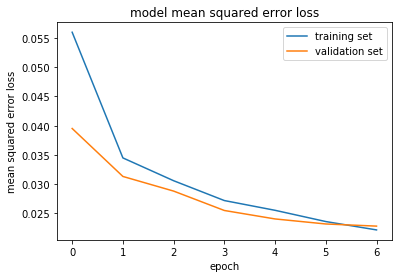

In [9]:
# Plot the training and validaiton loss for each epoch

# First print the keys contained in the history object
print(history_object.history.keys())

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [10]:
# Only as a completely final step, test the model on the test data

print("Testing...")

test_loss = model.evaluate_generator(test_generator,val_samples=2*len(test_samples))
print("Test loss: {}".format(test_loss) )

Testing...
Test loss: 0.02020052326889094


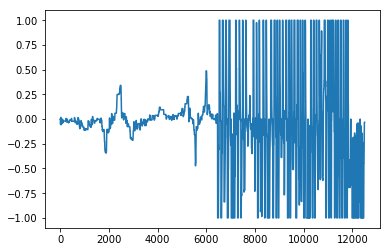

In [11]:
# Plot steering angles as a function of time, which is
# useful for debugging.

plt.plot(testing_angles)
plt.show()